In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

import numpy as np
from matplotlib import pyplot as plt

from src.plot_utils import plot_sample
from src.cfd import CFD
from src.cfd_utils import TIME_STEP

# Load data

In [2]:
channels = [17]

file_events = {}
for channel in channels:
    file_events[channel] = np.load(PWD + f'/data/filtered/channel_{channel}_filtered.npz', allow_pickle=True)['arr_0'].flat[0]

In [3]:
file_events[17].keys()

dict_keys(['sample_ampl', 'sample_t0', 'eventIDSampic', 'sample_channel'])

In [4]:
file_events[17]['sample_ampl'].shape

(19597, 2, 64)

# Generate dataset

## Generate data

In [5]:
_all_X_ch0 = []
all_X = []
all_y = []
_all_y_ch_non0 = []

cfd = CFD(fraction=0.25)
for channel in channels:
    for sample_ampl, sample_t0 in zip(file_events[channel]['sample_ampl'], file_events[channel]['sample_t0']):
        timestamp = cfd.predict(sample_ampl[0]) 
        timestamp += (sample_t0[0] - sample_t0[1]) / TIME_STEP
        
        _all_X_ch0.append(sample_ampl[0])                  # amplitudes from channel 0 (not in the dataset)
        all_X.append(sample_ampl[1])                       # X - amplitudes from channel non-0
        all_y.append(timestamp)                            # y - timestamp from channel 0
        _all_y_ch_non0.append(cfd.predict(sample_ampl[1])) # timestamps from channel non-0 (not in the dataset)
        
_all_X_ch0 = np.array(_all_X_ch0)
all_X = np.array(all_X)
all_y = np.array(all_y)
_all_y_ch_non0 = np.array(_all_y_ch_non0)

## Eliminate outliers

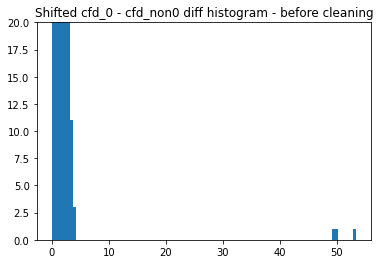

In [6]:
plt.hist(abs(all_y - _all_y_ch_non0), bins=100)
plt.ylim(0, 20)
plt.title('Shifted cfd_0 - cfd_non0 diff histogram - before cleaning')
plt.show()

In [7]:
MAX_DIFF = 3

mask = abs(all_y - _all_y_ch_non0) < MAX_DIFF

_all_X_ch0_cleaned = _all_X_ch0[mask]
all_X_cleaned = all_X[mask]
all_y_cleaned = all_y[mask]
_all_y_ch_non0_cleaned = _all_y_ch_non0[mask]

len(all_X_cleaned)

19570

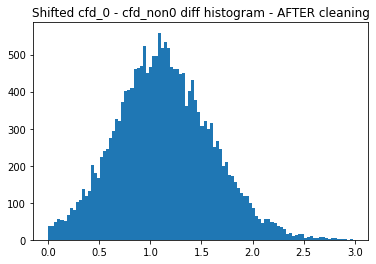

In [8]:
plt.hist(abs(all_y_cleaned - _all_y_ch_non0_cleaned), bins=100)
plt.title('Shifted cfd_0 - cfd_non0 diff histogram - AFTER cleaning')
plt.show()

## Save

In [9]:
np.savez_compressed(PWD + f'/data/dataset.npz', X=np.array(all_X_cleaned), y=np.array(all_y_cleaned))

# Check

In [10]:
def normalize(X, n_baseline=20):
    X -= np.mean(X[:n_baseline])
    X /= X.max()
    return X

def plot_samples(indices):
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
        plot_sample(normalize(_all_X_ch0_cleaned[idx]))
        y = cfd.predict(_all_X_ch0_cleaned[idx])
        plt.axvline(y, c='red')
        plt.title(f'{y:0.4f}')
        
        plt.subplot(2, 4, 4 + i + 1)
        plot_sample(normalize(all_X_cleaned[idx]))
        plt.axvline(all_y_cleaned[idx], c='red')
        plt.title(f'{all_y_cleaned[idx]:0.4f}')
        plt.axhline(0, c='black', linestyle='--')
        plt.axhline(0.25, c='orange', linestyle='--')

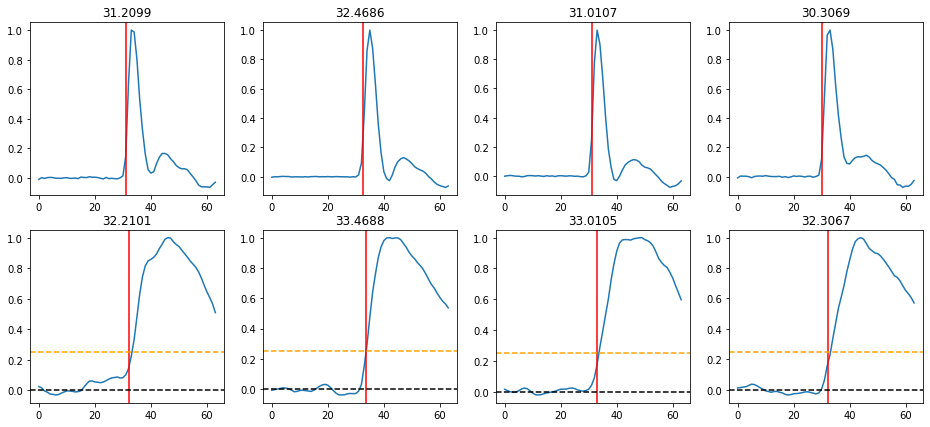

In [11]:
plt.figure(figsize=(16, 7))
plot_samples([10, 11, 12, 13])

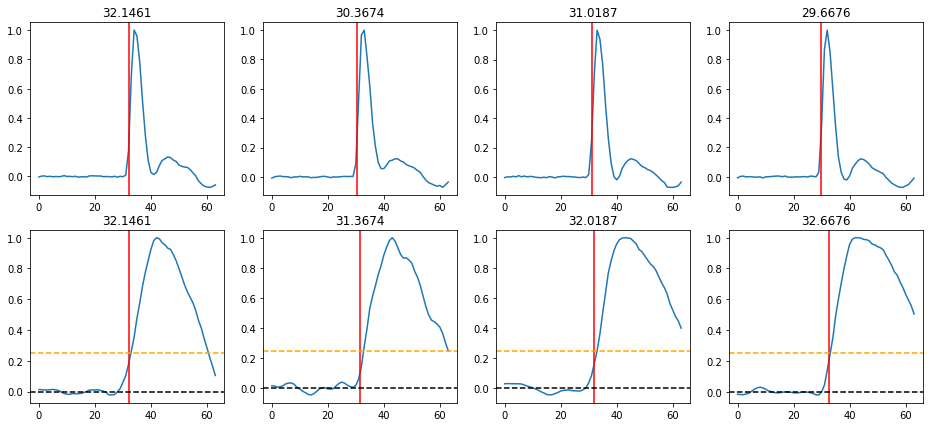

In [12]:
plt.figure(figsize=(16, 7))
plot_samples([500, 1000, 2000, 3000])

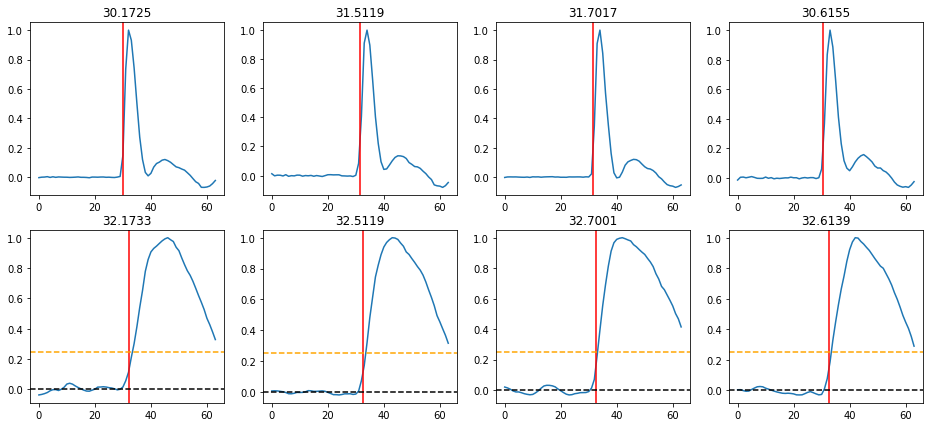

In [13]:
plt.figure(figsize=(16, 7))
plot_samples([4000, 5000, 6000, 7000])

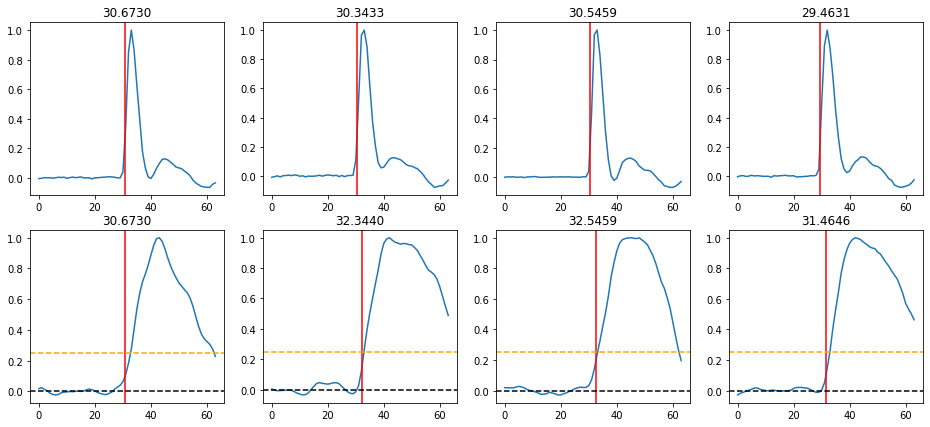

In [14]:
plt.figure(figsize=(16, 7))
plot_samples([8000, 9000, 10000, 11000])